# GHOST: Generative High-fidelity One Shot Transfer

<img src="https://drive.google.com/uc?export=view&id=1MdOWxP9CqyqmW6t9MQ6-gcfEux54zbqP">

In [ ]:
#@markdown #**Check GPU and CUDA version**

!nvidia-smi

!nvcc --version

Tue Sep 27 07:30:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#@markdown #**Clone github & download models**

!git clone https://github.com/sberbank-ai/sber-swap.git
%cd sber-swap

# load arcface
!wget -P ./arcface_model https://github.com/sberbank-ai/sber-swap/releases/download/arcface/backbone.pth
!wget -P ./arcface_model https://github.com/sberbank-ai/sber-swap/releases/download/arcface/iresnet.py

# load landmarks detector
!wget -P ./insightface_func/models/antelope https://github.com/sberbank-ai/sber-swap/releases/download/antelope/glintr100.onnx
!wget -P ./insightface_func/models/antelope https://github.com/sberbank-ai/sber-swap/releases/download/antelope/scrfd_10g_bnkps.onnx

# load model itself
!wget -P ./weights https://github.com/sberbank-ai/sber-swap/releases/download/sber-swap-v2.0/G_unet_2blocks.pth

# load super res model
!wget -P ./weights https://github.com/sberbank-ai/sber-swap/releases/download/super-res/10_net_G.pth

Cloning into 'sber-swap'...
remote: Enumerating objects: 695, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 695 (delta 35), reused 21 (delta 21), pack-reused 645
Receiving objects: 100% (695/695), 94.00 MiB | 15.52 MiB/s, done.
Resolving deltas: 100% (162/162), done.
/content/sber-swap
--2022-09-27 07:31:16--  https://github.com/sberbank-ai/sber-swap/releases/download/arcface/backbone.pth
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/ai-forever/sber-swap/releases/download/arcface/backbone.pth [following]
--2022-09-27 07:31:17--  https://github.com/ai-forever/sber-swap/releases/download/arcface/backbone.pth
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://objects.githubusercontent.com/git

In [ ]:
#@markdown #**Install required libraries**

!pip install mxnet-cu101mkl
!pip install onnxruntime-gpu==1.8
!pip install insightface==0.2.1
!pip install kornia==0.5.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 712.3 MB 367 bytes/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 31.3 MB 1.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 48.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 285 kB 32.3 MB/s 


In [ ]:
#@markdown #**Preparation**

import cv2
import torch
import time
import os

from utils.inference.image_processing import crop_face, get_final_image, show_images
from utils.inference.video_processing import read_video, get_target, get_final_video, add_audio_from_another_video, face_enhancement
from utils.inference.core import model_inference

from network.AEI_Net import AEI_Net
from coordinate_reg.image_infer import Handler
from insightface_func.face_detect_crop_multi import Face_detect_crop
from arcface_model.iresnet import iresnet100
from models.pix2pix_model import Pix2PixModel
from models.config_sr import TestOptions

/usr/local/lib/python3.7/dist-packages/kornia/augmentation/augmentation.py:1833: DeprecationWarning: GaussianBlur is no longer maintained and will be removed from the future versions. Please use RandomGaussianBlur instead.
  category=DeprecationWarning,
/usr/local/lib/python3.7/dist-packages/mxnet/numpy/utils.py:36: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bool = onp.bool
/content/sber-swap/models/networks/normalization.py:68: DeprecationWarning: invalid escape sequence \D
  parsed = re.search('spade(\D+)(\d)x\d', config_text)
/content/sber-swap/utils/inference/util.py:165: DeprecationWarning: invalid escape sequence \d
  return [atoi(c) for c in re.split('(\d+)

In [ ]:
#@markdown #**Initialize models**

app = Face_detect_crop(name='antelope', root='./insightface_func/models')
app.prepare(ctx_id= 0, det_thresh=0.6, det_size=(640,640))

# main model for generation
G = AEI_Net(backbone='unet', num_blocks=2, c_id=512)
G.eval()
G.load_state_dict(torch.load('weights/G_unet_2blocks.pth', map_location=torch.device('cpu')))
G = G.cuda()
G = G.half()

# arcface model to get face embedding
netArc = iresnet100(fp16=False)
netArc.load_state_dict(torch.load('arcface_model/backbone.pth'))
netArc=netArc.cuda()
netArc.eval()

# model to get face landmarks
handler = Handler('./coordinate_reg/model/2d106det', 0, ctx_id=0, det_size=640)

# model to make superres of face, set use_sr=True if you want to use super resolution or use_sr=False if you don't
use_sr = True
if use_sr:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    torch.backends.cudnn.benchmark = True
    opt = TestOptions()
    #opt.which_epoch ='10_7'
    model = Pix2PixModel(opt)
    model.netG.train()

input mean and std: 127.5 127.5
find model: ./insightface_func/models/antelope/glintr100.onnx recognition
find model: ./insightface_func/models/antelope/scrfd_10g_bnkps.onnx detection
set det-size: (640, 640)
loading ./coordinate_reg/model/2d106det 0
input mean and std: 127.5 127.5
find model: ./insightface_func/models/antelope/glintr100.onnx recognition
find model: ./insightface_func/models/antelope/scrfd_10g_bnkps.onnx detection
set det-size: (640, 640)
Network [LIPSPADEGenerator] was created. Total number of parameters: 72.2 million. To see the architecture, do print(network).
Load checkpoint from path:  weights/10_net_G.pth


In [24]:
#@markdown #**Upload source image and video**

#@markdown choose not really long videos, coz it can take a lot of time otherwise  

#@markdown choose source image as a photo -- preferable a selfie of a person

target_type = 'image' #@param ["video", "image"]


source_path = 'examples/images/conor.jpg' #@param {type:"string"}
target_path = 'examples/images/beckham.jpg' #@param {type:"string"}
path_to_video = 'examples/videos/nggyup.mp4' #@param {type:"string"}

source_full = cv2.imread(source_path)
OUT_VIDEO_NAME = "examples/results/result.mp4"
crop_size = 224 # don't change this


# check, if we can detect face on the source image

try:    
    source = crop_face(source_full, app, crop_size)[0]
    source = [source[:, :, ::-1]]
    print("Everything is ok!")
except TypeError:
    print("Bad source images")

# read video
if target_type == 'image':
    target_full = cv2.imread(target_path)
    full_frames = [target_full]
else:
    full_frames, fps = read_video(path_to_video)
target = get_target(full_frames, app, crop_size)

Everything is ok!


In [25]:
#@markdown #**Inference**


batch_size =  40#@param {type:"integer"}

START_TIME = time.time()

final_frames_list, crop_frames_list, full_frames, tfm_array_list = model_inference(full_frames,
                                                                                   source,
                                                                                   target,
                                                                                   netArc,
                                                                                   G,
                                                                                   app,
                                                                                   set_target = False,
                                                                                   crop_size=crop_size,
                                                                                   BS=batch_size)

if use_sr:
    final_frames_list = face_enhancement(final_frames_list, model)

if target_type == 'video':
  get_final_video(final_frames_list,
                  crop_frames_list,
                  full_frames,
                  tfm_array_list,
                  OUT_VIDEO_NAME,
                  fps, 
                  handler)
  
  add_audio_from_another_video(path_to_video, OUT_VIDEO_NAME, "audio")

  print(f'Full pipeline took {time.time() - START_TIME}')
  print(f"Video saved with path {OUT_VIDEO_NAME}")
else:
  result = get_final_image(final_frames_list, crop_frames_list, full_frames[0], tfm_array_list, handler)
  cv2.imwrite('examples/results/result.png', result)

100%|██████████| 1/1 [00:00<00:00, 41.01it/s]
1it [00:00, 201.50it/s]
1it [00:00, 801.20it/s]
100%|██████████| 1/1 [00:00<00:00, 11366.68it/s]
1it [00:00,  6.41it/s]


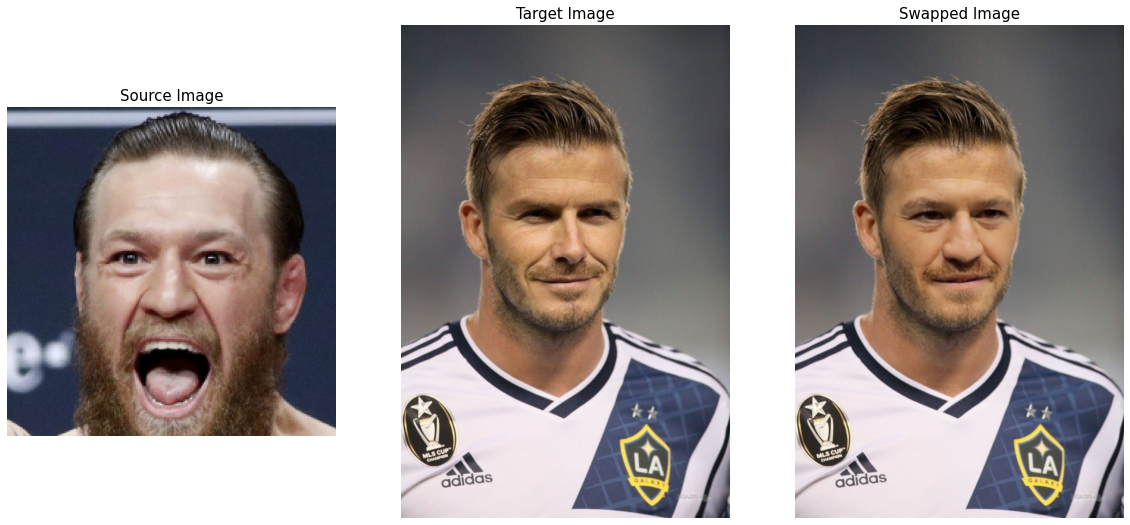

In [26]:
#@markdown #**Visualize Image to Image swap**

import matplotlib.pyplot as plt

show_images([source[0][:, :, ::-1], target_full, result], ['Source Image', 'Target Image', 'Swapped Image'], figsize=(20, 15))


In [ ]:
#@markdown #**Visualize Video Swap**

from IPython.display import HTML
from base64 import b64encode

video_file = open(OUT_VIDEO_NAME, "r+b").read()
video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"

HTML(f"""<video width={800} controls><source src="{video_url}"></video>""")

Output hidden; open in https://colab.research.google.com to view.